In [188]:
# !pip install gymnasium pygame numpy matplotlib
# # You may optionally install imageio-ffmpeg to ensure video recording works in some environments
# !pip install imageio-ffmpeg

In [189]:
import numpy as np
import random
import gymnasium as gym
from gymnasium import spaces
from gymnasium.wrappers import RecordVideo
import pygame
import matplotlib.pyplot as plt
from copy import deepcopy
from datetime import datetime

In [190]:
class GridMazeEnv(gym.Env):
    metadata = {"render_modes": ["human", "rgb_array"], "render_fps": 4}

    def __init__(self, grid_size, goal, bad_cells, goal_reward=10, bad_reward=-10,step_reward = 0, cell_size=64, render_mode="human"):
        super().__init__()
        self.grid_size = grid_size
        self.goal = tuple(goal)
        self.bad_cells = [tuple(b) for b in bad_cells]
        self.cell_size = cell_size
        self.width = grid_size * cell_size
        self.height = grid_size * cell_size
        self.render_mode = render_mode

        # action and observation spaces
        self.action_space = spaces.Discrete(4)
        # observation: agent_x, agent_y, goal_x, goal_y, bad1_x, bad1_y, bad2_x, bad2_y
        self.observation_space = spaces.MultiDiscrete([grid_size, grid_size, grid_size, grid_size, grid_size, grid_size, grid_size, grid_size])

        # render
        self.screen = None
        self.clock = None

        # transition probabilities
        # mapping actions to delta
        self._action_delta = {0: (-1, 0), 1: (1, 0), 2: (0, -1), 3: (0, 1)}
        # for perpendiculars
        self._perpendicular = {0: [2,3], 1: [2,3], 2: [0,1], 3: [0,1]}

        # reward config
        self.reward_goal = goal_reward
        self.reward_bad = bad_reward
        self.reward_step = step_reward

        self.agent_pos = (0,0)

    def seed(self, seed=None):
        random.seed(seed)
        np.random.seed(seed)

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        # place agent randomly not on goal or bad cells
        self.agent_pos = (0,0)
        obs = np.array([self.agent_pos[0], self.agent_pos[1], self.goal[0], self.goal[1], self.bad_cells[0][0], self.bad_cells[0][1], self.bad_cells[1][0], self.bad_cells[1][1]], dtype=np.int32)
        return obs, {}

    def _move(self, pos, action):
        """Deterministic move clamped to grid bounds."""
        dx, dy = self._action_delta[action]
        newx = min(max(pos[0] + dx, 0), self.grid_size-1)
        newy = min(max(pos[1] + dy, 0), self.grid_size-1)
        return (newx, newy)

    def step(self, action):
        # stochastic outcome
        r = random.random()
        if r < 0.7:
            chosen = action
        elif r < 0.85:
            chosen = self._perpendicular[action][0]
        else:
            chosen = self._perpendicular[action][1]

        newpos = self._move(self.agent_pos, chosen)
        self.agent_pos = newpos

        # compute reward and done
        if self.agent_pos == self.goal:
            reward = self.reward_goal
            terminated = True
        elif self.agent_pos in self.bad_cells:
            reward = self.reward_bad
            terminated = True
        else:
            reward = self.reward_step
            terminated = False

        obs = np.array([self.agent_pos[0], self.agent_pos[1], self.goal[0], self.goal[1], self.bad_cells[0][0], self.bad_cells[0][1], self.bad_cells[1][0], self.bad_cells[1][1]], dtype=np.int32)
        return obs, reward, terminated, False, {}

    def render(self):
        # supports rgb_array and human
        if self.screen is None:
            pygame.init()
            if self.render_mode == "human":
                self.screen = pygame.display.set_mode((self.width, self.height))
                pygame.display.set_caption("Grid Maze")
            else:
                self.screen = pygame.Surface((self.width, self.height))
            self.clock = pygame.time.Clock()

        # white background
        self.screen.fill((255,255,255))

        # grid lines
        for x in range(0, self.width, self.cell_size):
            pygame.draw.line(self.screen, (0,0,0), (x,0), (x,self.height))
        for y in range(0, self.height, self.cell_size):
            pygame.draw.line(self.screen, (0,0,0), (0,y), (self.width,y))

        # draw goal and bads
        gx, gy = self.goal
        goal_rect = pygame.Rect(gy*self.cell_size, gx*self.cell_size, self.cell_size, self.cell_size)
        pygame.draw.rect(self.screen, (0,255,0), goal_rect)
        for b in self.bad_cells:
            bx, by = b
            rect = pygame.Rect(by*self.cell_size, bx*self.cell_size, self.cell_size, self.cell_size)
            pygame.draw.rect(self.screen, (255,0,0), rect)

        # draw agent
        ax, ay = self.agent_pos
        cx = ay*self.cell_size + self.cell_size//2
        cy = ax*self.cell_size + self.cell_size//2
        pygame.draw.circle(self.screen, (0,0,255), (cx, cy), self.cell_size//4)

        if self.render_mode == "human":
            pygame.display.get_surface().blit(self.screen, (0,0))
            pygame.display.flip()
            self.clock.tick(self.metadata["render_fps"])
        else:
            return np.transpose(pygame.surfarray.array3d(self.screen), (1,0,2))

    def close(self):
        if self.screen is not None:
            pygame.quit()
            self.screen = None
            self.clock = None

In [191]:

def pos_to_state_idx(pos, grid_size=5):
    """Map (x,y) to state index in range [0, grid_size*grid_size-1]"""
    return pos[0] * grid_size + pos[1]


def state_idx_to_pos(idx, grid_size=5):
    x = idx // grid_size
    y = idx % grid_size
    return (x, y)


In [192]:
def build_transition_and_reward(env: GridMazeEnv):
    """
    Build P and R assuming reward depends only on the cell reached
    (no expectation over stochastic outcomes).
    """
    S = env.grid_size * env.grid_size
    A = env.action_space.n
    P = np.zeros((S, A, S))
    R = np.zeros((S, A))

    for s in range(S):
        pos = state_idx_to_pos(s, env.grid_size)
        for a in range(A):
            # possible stochastic outcomes
            outcomes = [(a, 0.7), (env._perpendicular[a][0], 0.15), (env._perpendicular[a][1], 0.15)]
            for act, prob in outcomes:
                newpos = env._move(pos, act)
                s2 = pos_to_state_idx(newpos, env.grid_size)
                P[s, a, s2] += prob

            # pick the "main" intended next cell (ignore stochasticity)
            intended_next = env._move(pos, a)
            if intended_next == env.goal:
                R[s, a] = env.reward_goal
            elif intended_next in env.bad_cells:
                R[s, a] = env.reward_bad
            else:
                R[s, a] = env.reward_step
    return P, R


def policy_evaluation(policy, P, R, V, gamma, theta=1e-3):
    S, A = P.shape[0], P.shape[1]
    # V = np.zeros(S)
    iters = 0
    while True:
        iters +=1
        old_v = V.copy()
        delta = 0.0
        for s in range(S):
            a = policy[s]
            v = V[s]
            V[s] = sum(P[s, a, s2] * (R[s, a] + gamma * old_v[s2]) for s2 in range(S))
            delta = max(delta, abs(old_v[s] - V[s]))
        if delta < theta:
            break
    print(f"Took {iters} iterations to converge for ploicy_eval")
    return V


def policy_improvement(V, P, R, gamma):
    S, A = P.shape[0], P.shape[1]
    policy = np.zeros(S, dtype=int)
    for s in range(S):
        action_values = np.zeros(A)
        for a in range(A):
            action_values[a] = sum(P[s,a,s2] * (R[s,a] + gamma * V[s2]) for s2 in range(S))
        best_a = int(np.argmax(action_values))
        policy[s] = best_a
    return policy


def policy_iteration(P, R, gamma, max_iters=100):
    S, A = P.shape[0], P.shape[1]
    # initialize with random policy
    policy = np.random.randint(0, A, size=S)
    iters = 0
    V = np.zeros(S)
    while True:
        iters += 1
        print(f"Iteration number {iters}")
        V = policy_evaluation(policy, P, R, V, gamma)
        new_policy = policy_improvement(V, P, R, gamma)
        if np.array_equal(policy, new_policy) or iters >= max_iters:
            return new_policy, V, iters
        policy = new_policy




Iteration number 1
Took 70 iterations to converge for ploicy_eval
Iteration number 2
Took 67 iterations to converge for ploicy_eval
Iteration number 3
Took 77 iterations to converge for ploicy_eval
Iteration number 4
Took 46 iterations to converge for ploicy_eval
Iteration number 5
Took 11 iterations to converge for ploicy_eval
Converged in 5 policy iterations
Time taken: 0:00:00.134997
[['↓' '↓' 'X' '↓' '↓']
 ['↓' '↓' '→' '↓' '↓']
 ['→' '↓' 'X' '↓' '←']
 ['→' '→' 'O' '←' '←']
 ['→' '→' '↑' '←' '←']]


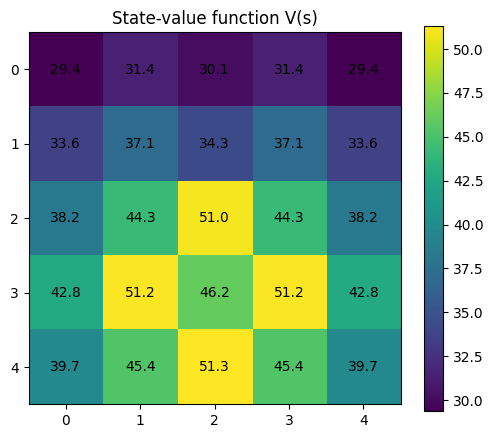

In [193]:
# Fix goal and bad positions for reproducibility
grid_size=5
all_positions = set((0,0))

while len(all_positions)<2:
    pos = (random.randrange(grid_size), random.randrange(grid_size))
    if pos not in all_positions:
        fixed_goal = pos
        all_positions.add(pos)


fixed_bads = []
while len(fixed_bads) < 2:
    pos = (random.randrange(grid_size), random.randrange(grid_size))
    if pos not in all_positions:
        fixed_bads.append(pos)
        all_positions.add(pos)

# fixed_goal = (2,4)
# fixed_bads = [(0,3), (3,0)]
start = datetime.now()
env = GridMazeEnv(grid_size=grid_size, goal=fixed_goal, bad_cells=fixed_bads, goal_reward=10, bad_reward=-10, step_reward = 0, render_mode="rgb_array")
# env.seed(45425)
P, R = build_transition_and_reward(env)

policy, V, iterations = policy_iteration(P, R, gamma=0.9)
print(f"Converged in {iterations} policy iterations")
end = datetime.now()
print(f"Time taken: {end-start}")


# reshape policy and V to grid for visualization
policy_grid = np.array([policy[pos_to_state_idx((i,j), env.grid_size)] for i in range(env.grid_size) for j in range(env.grid_size)])
policy_grid = policy_grid.reshape((env.grid_size, env.grid_size))
V_grid = np.array([V[pos_to_state_idx((i,j), env.grid_size)] for i in range(env.grid_size) for j in range(env.grid_size)])
V_grid = V_grid.reshape((env.grid_size, env.grid_size))

arrow_map = {
    0: "↑",  # Up
    1: "↓",  # Down
    2: "←",  # Left
    3: "→"   # Right
}
arrow_grid = np.vectorize(arrow_map.get)(policy_grid)
gx, gy = fixed_goal
arrow_grid[gx, gy] = "O"  # goal cell

for bx, by in fixed_bads:
    arrow_grid[bx, by] = "X"  # bad cells
print(arrow_grid)

# plot value function heatmap
plt.figure(figsize=(6,5))
plt.title('State-value function V(s)')
plt.imshow(V_grid, origin='upper')
for i in range(env.grid_size):
    for j in range(env.grid_size):
        plt.text(j, i, f"{V_grid[i,j]:.1f}", ha='center', va='center')
plt.colorbar()
plt.show()


In [194]:
# create an env that uses the same fixed instance and rgb_array rendering

# wrap to record every episode
video_env = RecordVideo(env, video_folder='.', episode_trigger=lambda e: True, fps=4)

obs, _ = video_env.reset()
done = False
steps = 0
while not done and steps < 200:
    # compute agent pos state
    agent_pos = (int(obs[0]), int(obs[1]))
    s = pos_to_state_idx(agent_pos, env.grid_size)
    a = int(policy[s])
    obs, reward, terminated, truncated, info = video_env.step(a)
    frame = video_env.render()  # returns rgb array
    steps += 1
    done = terminated or truncated
#render last step
obs, reward, terminated, truncated, info = video_env.step(a)
video_env.close()
print('Recorded video to  (check this folder)')


Recorded video to  (check this folder)


/usr/local/lib/python3.12/dist-packages/gymnasium/wrappers/rendering.py:293: UserWarning: WARN: Overwriting existing videos at /content folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(
